In [1]:
from scipy.io import loadmat

import mne
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Flatten, Conv1D, 
                                     MaxPooling1D, GlobalAveragePooling1D)
from tensorflow.keras import utils

import itertools

import matplotlib.pyplot as plt

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


### Info on the study I am trying to replicate and improve on
1. The full study: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4436356/
2. The data description (including data dictionary): https://lampx.tugraz.at/~bci/database/004-2015/description.pdf

### Background on MNE

The primary library I will be using to organize, visualize, and preprocess my data is MNE for Python.

MNE is the most popular python extension for EEG work, and for good reason. It is a fairly robust tool, and has excellent documentation, which can be found here: https://mne.tools/stable/index.html

### Loading full dataset in raw unaltered format

Here we'll ingest all the raw data from our all participants such that it can be manipulated programmatically as dictionaries going forward. Each dictionary will be named according to the kind of data within it, and every dictionary will have the same keys that correspond to experiment sessions.

E.g., the data_dict will include all the raw data (EEG samples). Within that dictionary, the key 'sub_A_sesh_1' will contain all the data from subject A session 1.

As a note, the channel names (locations on the head on which the 30 electrodes were placed) are not recorded inside the dataset. As a result, I will assume the data is stored in the dataset in the same order that the channels are listed in the study documentation listing the electrodes used. Even if the channels names are incorrectly ordered, it won't impact my ability to answer the problem statement, because I can still construct a model which predicts yes/no. However, I won't be able to create visualizations that map the data to areas of the brain.

I built a script to do this ingestion - please see the script file in the project repo for code.

After running, this script will load several dictionaries into memory, as well as other needed objects:
- raw_dict - containing MNE raw objects with all the data
- event_dict - which indicates the sample number at which each stimulus was applied
- y_dict - which has the type of experiment conducted in each trial
- info - file used to create MNE raw objects including channel names, type, and sampling frequency
- events_explained - dictionary which provides the names for each of the five trial types
- ch_names - list of all channel names

In [161]:
%run data_ingester.py

### Visualizing the data

MNE has many different tools for visualizing data. We'll use several throughout this analysis, but most importantly is just viewing the raw signal, as below.

In [5]:
#plotting the first 5 channels over the first 2 seconds
data, times = raw_dict['sub_A_sesh_1'][0:5, 0:512]

plt.plot(times, data.T, label=ch_names[0:5])
plt.xlabel('time (s)')
plt.ylabel('EEG data (T)')
plt.legend()

**Insert screenshot of image from above**

### Combining our raw data for subject A with when trials occurred using MNE epochs

To do this, we'll construct the events array as follows:
- 3 columns x number of trials in dataset
- First column is the sample # where the trial occurred - locates event in time in our data array
    - We'll need to transform this in our data. MNE looks for the event as the time at which the stimulus began, whereas in our dataset the timestamp we've been provided is when their trial started. The stimulus occured 3 seconds after the beginning of each trial in all cases.
- 2nd column is a 0 in our case - only used with analog signals
- 3rd column is the event ID, what kind of event this trial was testing

Based on this documentation:
https://mne.tools/0.16/auto_examples/io/plot_objects_from_arrays.html#sphx-glr-auto-examples-io-plot-objects-from-arrays-py
https://mne.tools/0.16/generated/mne.EpochsArray.html#mne.EpochsArray 
https://mne.tools/dev/auto_tutorials/intro/20_events_from_raw.html 
https://mne.tools/stable/glossary.html#term-events

### Generating our data for loading into our neural networks
In general, the goal here is to get ready to load our data into neural networks. There are a number of different considerations for how we might want to load the data:
1. Creating the most accurate predictor possible
2. Commercializability of the result

Steps to get there:
1. Preprocess / slice the data in many different ways & see how the neural net performs on each. Each step notes whether this transformation needs to happen on raw data vs epoched data, as well as whether to be done on individual data or the entire dataset



    - **Baseline correction** (done in process of epoch creation)
        - Calculate the mean reading in the pre-stimulus period of each trial and then subtract that mean from the entire trial period to control for the state of mind at the time of each trial
        - Read more here: https://neuro.inf.unibe.ch/AlgorithmsNeuroscience/Tutorial_files/BaselineCorrection.html
        - Is this useful in an ongoing basis if we were really building a device? Because the device won't know when the event is going to occur ahead of time. Talk this through with Sophie / Eric but I think I can skip this? Or maybe on an ongoing basis the software could guess when events are occuring with random sampling and do baseline analyses? Still seems potentially error prone.
    - **Resample data** at a few different levels (resampling automatically includes a high pass filter to ensure aliasing does not occur in downsampling) - applied to epoch objects:
        - Keep every 8th recording (Gamma waves in brain at 30Hz+, so should not decimate any more than this)
        - Keep every 4th recording
        - Keep every 2nd recording
        - I should decimate in the epoch rather than the raw data to avoid shifting the events and missing exact timings: https://mne.tools/0.22/overview/faq.html#what-are-all-these-options-for-resampling-decimating-and-binning-data
    - **Averaged data** - generally frowned upon in EEG signal processing it sounds like. Here is MNE tool, but sounds like better to just do on my own: https://mne.tools/0.22/generated/mne.SourceEstimate.html#mne.SourceEstimate.bin
        - Average each group of 32 recordings
        - Average each group of 8 recordings
        - Average each group of 4 recordings
        - Given that it is frowned upon, do this only if I can't get results any other way
    - **Using the filters they used in the original study**:
        1. Exclude the channels noted here for having artifacts: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4436356/table/pone.0123727.t001/
            - Note that I think this is not good practice for a real device - you can't just throw out data you don't like
            - See how these channels look after various of the above transformations
        2. Use Common Spatial Pattern filters to transform the data - see this paper for full explanation: https://sci-hub.se/10.1109/MSP.2008.4408441


    1. How big should the image be that I pass to the neural net? E.g., how much before the stimulus and how long after it should the slice be that I feed in as input?
    3. How many levels deep should the network be? Step size, filter size, etc.
    4. Is there a way to give more weight to the trials for a particular respondent? That way I could tune a custom model for each person while still getting the benefit of the 9X larger sample size from all the respondents

**The starting point for analysis going forward is MNE raw objects** These objects contain all the sample data, channel names, and sample rate for all of our data, and the first of our preprocessing steps will occur on those raw objects.

### Preprocess the data prior to modeling

In order to grid search for the best parameters to use in preprocessing our data, I will set up a pipeline to perform our preprocessing steps in automated fashion and test the results. The steps we will be taking are below, along with a fuller explanation of each:
**1. Filtering**
**2. Dropping channels**
**3. Baseline correction**
**4. Dropping artifacts via SSP**
**5. Decimate data**
**6. Select sample length**
**7. Detrend data**
**7. Reject epochs based on spikiness or flatness of data**
**8. Scaling the data**


**Filtering**  Reject and remove very low and high frequency signals from the dataset. In general human brainwaves are between 4 and 35 Hz when awake. As a result, we will experiment with resulting higher and lower frequencies of signal from our dataset to see if it results in a clearer signal.

**Dropping Channels** We will experiment with dropping sets of channels that are particularly noisy. In order to maintain standardization across the dataset (and in line with what how decisions would be made in a project oriented around commercialization), we will drop the same channels across all datasets, simulating a device with fewer electrodes which would be used in production.

**Baseline correction** finds the mean reading for a sample of time and then subtracts that mean from the data in the entire epoch. The first number in the tuple is the time in seconds (within the epoch) to start taking that mean (or if None the beginning of the epoch), and the second number in the tuple is the final time in seconds to include in that baseline mean. Note that the stimulus time is equal to 0. Then that computed mean is subtracted from every sample in the epoch.

**SSP (Signal Space Projection)**  Should be done before independent component analysis (ICA), which is similarly focused on removing portions of the signal. SSP creates 'projectors' which, in descending order, capture the signal in a dataset. Can be thought of similarly to principal component analysis.

**Detrending** attempts to solve for noise in the data within each epoch. Setting option 0 removes DC noice in the readings (to correct for DC slope introduced by DC converter in the amplifier when signals are collected), while setting option 1 applies a linear detrend (fits a linear regression to the epoch and subtracts from each sample).

**Calculate and remove SSP from the data to remove artifacts**
Signal space projectors can be thought of as an equivalent for principal component analysis in other data formats. Essentially we will calculate the 'projections' running through each epoch and remove those that are creating noise in the data.

**Resample the data**
We're using resampling here, which automatically applies a high pass filter to avoid aliasing. Doing so will introduce some distortions at the beginning and end of each epoch, so we shouldn't use data from the very beginning and end of each of those 10 second periods.

    #Baseline finds a mean over a period and subtracts from all samples in epoch
    #Picks pulls all channels in the picks list into the epoch (rest are dropped)
    #Detrend applies linear or DC detrend
    #Reject drops epochs with too much variation from peak to peak
    #Flat drops epochs with too little variation from peak to peak

**First set of gridsearch options**

In [148]:
test_df.shape

(1224, 16)

In [144]:
l_freq_filter_options = [None, 1]
h_freq_filter_options = [None, 40, 50]
channels_to_drop_options = [[], ['AFz', 'F7', 'F8'], 
                    ['AFz', 'F7', 'F8', 'T3', 'T4', 'P7', 'PO3', 'O1', 'PO4', 
                     'P8', 'C4', 'P6']]
baseline_correction_options = [None, (None, 0)]
projectors_to_apply_options = [None, slice(1), slice(1, 2)]
selected_frequency_options = [256, 128, 64]
tmin_options = [0]
tmax_options = [2, 4.5]
detrend_options = [None]
reject_options = [None] #Need to do this at individual level
flat_options = [None] #Need to do this at individual level
ica_to_exclude_options = [None]
scaler_options = ['robust']

In [139]:
#Create column names for test dataframe
columns = ['l_freq_filter',
           'h_freq_filter',
           'channels_to_drop',
           'baseline_correction',
           'projectors_to_apply',
           'selected_frequency',
           'tmin',
           'tmax',
           'detrend',
           'reject',
           'flat',
           'ica_to_exclude',
           'scaler']

In [119]:
#Create dataframe with all combinations of processings steps as rows
test_df = pd.DataFrame(itertools.product(l_freq_filter_options, 
                                         h_freq_filter_options, 
                                         channels_to_drop_options, 
                                         baseline_correction_options, 
                                         projectors_to_apply_options, 
                                         selected_frequency_options,
                                         tmin_options,
                                         tmax_options, 
                                         detrend_options,
                                         reject_options,
                                         flat_options,
                                         ica_to_exclude_options,
                                         scaler_options), 
                      columns=columns)

**Second set of gridsearch options**

In [149]:
#Create new preprocessing combinations
l_freq_filter_options = [None, 2]
h_freq_filter_options = [None, 35, 40]
channels_to_drop_options = [['F7'], 
                    ['AFz', 'F7', 'F8', 'T3', 'T4']]
baseline_correction_options = [None]
projectors_to_apply_options = [slice(1), slice(0, 2), slice(0, 5)]
selected_frequency_options = [256]
tmin_options = [0.3]
tmax_options = [3, 4.5]
detrend_options = [None]
reject_options = [None]
flat_options = [None]
ica_to_exclude_options = [None]
scaler_options = ['robust']

In [150]:
#Create function to concat new rows of combinations to our test dataframe
def concat_test_df(test_df):
    return pd.concat((test_df, 
                         pd.DataFrame(itertools.product(l_freq_filter_options, 
                                         h_freq_filter_options, 
                                         channels_to_drop_options, 
                                         baseline_correction_options, 
                                         projectors_to_apply_options, 
                                         selected_frequency_options,
                                         tmin_options,
                                         tmax_options, 
                                         detrend_options,
                                         reject_options,
                                         flat_options,
                                         ica_to_exclude_options,
                                         scaler_options), columns=columns)),
                        ignore_index=True)

In [151]:
#Add our new combinations to test df
test_df = concat_test_df(test_df=test_df)

**Third set of gridsearch options**

In [152]:
#Create new preprocessing combinations
l_freq_filter_options = [None]
h_freq_filter_options = [40]
channels_to_drop_options = [['AFz', 'F7', 'F8'],  
                    ['AFz', 'F7', 'F8', 'T3', 'T4', 'P7', 'PO3', 'O1', 'PO4', 
                     'P8', 'C4', 'P6']]
baseline_correction_options = [None]
projectors_to_apply_options = [slice(1)]
selected_frequency_options = [256]
tmin_options = [0.3]
tmax_options = [4.5]
detrend_options = [None, 0, 1]
reject_options = [None] #Need to do this at individual level
flat_options = [None] #Need to do this at individual level
ica_to_exclude_options = [None]
scaler_options = ['robust']

In [153]:
#Add our new combinations to test df
test_df = concat_test_df(test_df=test_df)

**Fourth set of gridsearch options**

In [154]:
#Create new preprocessing combinations
l_freq_filter_options = [None]
h_freq_filter_options = [40]
channels_to_drop_options = [['AFz', 'F7', 'F8'],
                    ['AFz', 'F7', 'F8', 'T3', 'T4', 'P7', 'PO3', 'O1', 'PO4', 
                     'P8', 'C4', 'P6']]
baseline_correction_options = [None]
projectors_to_apply_options = [slice(1), slice(0, 5, 2)]
selected_frequency_options = [256]
tmin_options = [-0.2]
tmax_options = [4.5, 5.5]
detrend_options = [None, 0]
reject_options = [None] #Need to do this at individual level
flat_options = [None] #Need to do this at individual level
ica_to_exclude_options = [None]
scaler_options = ['robust']

In [155]:
#Add our new combinations to test df
test_df = concat_test_df(test_df=test_df)

**Fifth set of gridsearch options**

In [156]:
#Create new preprocessing combinations
l_freq_filter_options = [None]
h_freq_filter_options = [40]
channels_to_drop_options = [['AFz', 'F7', 'F8']]
baseline_correction_options = [None]
projectors_to_apply_options = [slice(1)]
selected_frequency_options = [256]
tmin_options = [-0.2, 1]
tmax_options = [4.5, 5.5]
detrend_options = [None]
reject_options = [None] #Need to do this at individual level
flat_options = [None] #Need to do this at individual level
ica_to_exclude_options = [None, [0], [1], [0, 1], [0, 1, 2, 3, 4]]
scaler_options = ['robust', 'min_max']

In [157]:
#Add our new combinations to test df
test_df = concat_test_df(test_df=test_df)

In [158]:
#Drop duplicates to avoid retesting already tested combinations, 
#need to cast columns as strings to deduplicate because df contains lists
test_df = test_df.loc[test_df.astype(str).drop_duplicates(subset=
                                                          columns).index]

#reset index after removing duplicates
test_df.reset_index(drop=True, inplace=True)

Now we need to add the trial combinations we want to test to the dataframe. E.g., thinking about closing hand vs mental subtraction. From early tests, I know that the combinations below are the front-runners for best trials to use in our binary classification.

In [130]:
trial_combo_list = [(1, 5), (2, 4), (1, 3)]

In [131]:
#Add those combos to our test_df to save highest val accuracy achieved
test_df = test_df.reindex(columns=columns + 
                          [str(combo) for combo in trial_combo_list])

Finally, let's convert NaNs in the dataframe to Nones. MNE uses None as an input for many of the parameters we are trying to set, but NaN throws an error

In [159]:
test_df.replace(np.nan, None, inplace=True)

In [160]:
test_df.shape

(1358, 16)

### Now let's run through the entire set of preprocessing combinations in our test dataframe, model the results in a basic CNN, and save down our validation accuracy for each iteration

Note the model architecture used in this function is based on a model built by Justin Alvey here: https://justlv.medium.com/using-ai-to-read-your-thoughts-with-keras-and-an-eeg-sensor-167ace32e84a

Later in the project I will create custom architecture to improve accuracy, but this is a great place to start.

In [ ]:
for row in range(test_df.shape[0]):
    #Load each sessions data into an MNE raw object
    raw_dict = {}
    for key, value in data_dict.items():
        raw_dict[key] = mne.io.RawArray(value.T, info, verbose=0)
    
    #Filter data with bandpass. Note raw.filter applies in place
    for key, value in raw_dict.items():
        value.filter(l_freq=test_df.l_freq_filter[row], 
                     h_freq=test_df.h_freq_filter[row], 
                     method='fir', phase='zero', verbose=0)

    #Create epoch object with our raw objects and events arrays
    #Baseline (None, 0) finds the mean value of all samples before stimulus
    #Picks pulls all channels in the picks list into the epoch (rest are dropped)
    #Detrend applies linear or DC detrend
    #Reject drops epochs with too much variation from peak to peak
    #Flat drops epochs with too little variation from peak to peak
    channels_to_keep = [ch for ch in ch_names if 
                        ch not in test_df.channels_to_drop[row]]
    epoch_dict = {}
    for key, value in raw_dict.items():
        epoch_dict[key] = mne.Epochs(value, events=event_dict[key], 
                                    event_id=events_explained, 
                                    tmin=-3, tmax=test_df.tmax[row], 
                                    baseline=test_df.baseline_correction[row],
                                    preload=True,
                                    picks=channels_to_keep, verbose=0,
                                    detrend=test_df.detrend[row],
                                    reject=test_df.reject[row],
                                    flat=test_df.flat[row],
                                    reject_tmin=test_df.tmin[row],
                                    reject_tmax=test_df.tmax[row])

    #Skip creating projectors step to save compute time if not being
    #applied in this iteration
    if test_df.projectors_to_apply[row]:
        #Create dictionary of top 5 signal space projection vectors for each epoch
        proj_dict = {}
        for key, value in epoch_dict.items():
            proj_dict[key] = mne.compute_proj_epochs(value, n_eeg=5, verbose=0)
        #apply projectors
        for key, value in epoch_dict.items():
            value.add_proj(proj_dict[key][test_df.projectors_to_apply[row]], 
                           verbose=0)
            value.apply_proj(verbose=0)

    #Skip creating ICA components step to save compute time if not
    #being applied in this iteration
    if test_df.ica_to_exclude[row]:
        #create and fit ICA object to epochs
        for key, value in epoch_dict.items():
            ica = mne.preprocessing.ICA(n_components=5, method='picard', 
                                        max_iter='auto', verbose=0)
            ica.fit(value, verbose=0)
            #Apply the ICA
            ica.apply(value, exclude=test_df.ica_to_exclude[row],
                     verbose=0)

    #Resample the data at a new frequency
    for key, value in epoch_dict.items():
        value.resample(sfreq=test_df.selected_frequency[row])

    #Standard scale data and extract the data we want to model on
    final_data_dict = {}
    #Use robust sklearn scaler
    if test_df.scaler[row] == 'robust':
        mne_scaler = mne.decoding.Scaler(scalings='median')
        for key, value in epoch_dict.items():
            #with scalings=median implements sklearn robust scaler
            final_data_dict[key] = (mne_scaler.
                                    fit_transform(value.
                                                  get_data(tmin=test_df.tmin[row], 
                                                           tmax=test_df.tmax[row])))
    #use min max scaling
    if test_df.scaler[row] == 'min_max':
        #Need to first populate the dict with unscaled data
        #Then can scale in place via iteration
        for key, value in epoch_dict.items():
            final_data_dict[key] = value.get_data(tmin=test_df.tmin[row], 
                                                  tmax=test_df.tmax[row])
        #Now min max scale across final data dict
        min_max_scaler = MinMaxScaler()
        #Iterate across each trial, transpose, and scale
        for key, value in final_data_dict.items():
            for i in range(value.shape[0]):
                value[i] = min_max_scaler.fit_transform(value[i].T).T


    #Create list of all trials in each session
    sesh_1_list = [sesh for sesh in list(final_data_dict.keys()) 
                   if 'sesh_1' in sesh]
    sesh_2_list = [sesh for sesh in list(final_data_dict.keys()) 
                   if 'sesh_2' in sesh]

    #Concatenate data from all trials together by session
    sesh_1_data = np.concatenate(([final_data_dict[key] for 
                                   key in sesh_1_list]), axis=0)
    sesh_2_data = np.concatenate(([final_data_dict[key] for 
                                   key in sesh_2_list]), axis=0)

    #Get corresponding list of trials combined by session
    sesh_1_y = []
    for key, value in y_dict.items():
        if key in sesh_1_list:
            for i, epoch in enumerate(epoch_dict[key].drop_log):
        #MNE drop log shows empty parens for epochs that were not dropped - 
        #these are the trials we are keeping in each iteration
                if epoch == ():
                    sesh_1_y.append(value[i])
    sesh_1_y = np.array(sesh_1_y)
    #repeat for session 2
    sesh_2_y = []
    for key, value in y_dict.items():
        if key in sesh_2_list:
            for i, epoch in enumerate(epoch_dict[key].drop_log):
        #MNE drop log shows empty parens for epochs that were not dropped - 
        #these are the trials we are keeping in each iteration
                if epoch == ():
                    sesh_2_y.append(value[i])
    sesh_2_y = np.array(sesh_2_y)


    #reshape data tensor to be loaded into neural network
    sesh_1_data = np.reshape(sesh_1_data, (sesh_1_data.shape[0],
                                           sesh_1_data.shape[2],
                                           sesh_1_data.shape[1]))
    sesh_2_data = np.reshape(sesh_2_data, (sesh_2_data.shape[0],
                                           sesh_2_data.shape[2],
                                           sesh_2_data.shape[1]))

    #reshape ys to one dimension
    sesh_1_y = np.reshape(sesh_1_y, sesh_1_y.shape[0])
    sesh_2_y = np.reshape(sesh_2_y, sesh_2_y.shape[0])

    #Assemble combinations of ys for each pairwise comparison between trials
    #In each combo, coding 1st trial type to 0, 2nd trial type to 1
    sesh_1_y_combo_dict = {}
    for combo in trial_combo_list:
        trial_list_temp = []
        for y in sesh_1_y:
            if y == combo[0]:
                trial_list_temp.append(0)
            if y == combo[1]:
                trial_list_temp.append(1)
        sesh_1_y_combo_dict[combo] = np.array(trial_list_temp)
    #Repeated for session 2
    sesh_2_y_combo_dict = {}
    for combo in trial_combo_list:
        trial_list_temp = []
        for y in sesh_2_y:
            if y == combo[0]:
                trial_list_temp.append(0)
            if y == combo[1]:
                trial_list_temp.append(1)
        sesh_2_y_combo_dict[combo] = np.array(trial_list_temp)

    #Create combo dict of data for each relevant combination of trials
    sesh_1_data_combo_dict = {}
    for combo in trial_combo_list:
        index_list = []
        for i, y in enumerate(sesh_1_y):
            if y == combo[0] or y == combo[1]:
                index_list.append(i)
        sesh_1_data_combo_dict[combo] = sesh_1_data[index_list]
    #Repeat for session 2
    sesh_2_data_combo_dict = {}
    for combo in trial_combo_list:
        index_list = []
        for i, y in enumerate(sesh_2_y):
            if y == combo[0] or y == combo[1]:
                index_list.append(i)
        sesh_2_data_combo_dict[combo] = sesh_2_data[index_list]



    #Create model to predict all combinations of trial types
    for combo in trial_combo_list:
        #Build the model
        model = Sequential()
        model.add(Conv1D(40, 6, strides=2, padding='same', activation='relu', 
                     input_shape=(sesh_1_data_combo_dict[combo].shape[1], 
                                  sesh_1_data_combo_dict[combo].shape[2])))
        model.add(Dropout(0.2))
        model.add(MaxPooling1D(2))
        model.add(Conv1D(40, 4, strides=1, padding='same', activation='relu'))
#         model.add(Dropout(0.2))
#         model.add(MaxPooling1D(2))
#         model.add(Conv1D(40, 3, strides=1, padding='same', activation='relu'))
        model.add(Dropout(0.2))
        model.add(MaxPooling1D(2))
        model.add(GlobalAveragePooling1D())
        model.add(Dense(50, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(1, activation='sigmoid'))

        model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

        #Fit the model
        history = model.fit(sesh_1_data_combo_dict[combo], 
                            sesh_1_y_combo_dict[combo], 
                            batch_size=60, epochs=8, 
                            validation_data=(sesh_2_data_combo_dict[combo], 
                                             sesh_2_y_combo_dict[combo]), 
                            verbose=0, workers=8)

        #Save the best validation accuracy achieved by each model
        test_df.loc[[row], [str(combo)]] = max(history.history['val_accuracy'])
    #Save the testing dataframe in case of a crash
    test_df.to_csv('data/preprocessing_grid_search.csv', index=False)

### Gridsearch results and takeaways

In [94]:
#View our results
test_df.sort_values('(1, 5)', ascending=False).head(10)

l_freq_filter  h_freq_filter  \
619            1.0             40   
147            0.1             40   
403            0.1             50   
73             0.1             40   
181            0.1             40   
439            1.0             40   
361            0.1             50   
583            1.0             40   
145            0.1             40   
365            0.1             50   

                                      channels_to_drop baseline_correction  \
619  [AFz, F7, F6, T3, T4, P7, PO3, O1, PO4, P8, C4...           (None, 0)   
147  [AFz, F7, F6, T3, T4, P7, PO3, O1, PO4, P8, C4...                None   
403  [AFz, F7, F6, T3, T4, P7, PO3, O1, PO4, P8, C4...           (None, 0)   
73                                       [AFz, F7, F6]                None   
181  [AFz, F7, F6, T3, T4, P7, PO3, O1, PO4, P8, C4...           (None, 0)   
439                                                 []                None   
361  [AFz, F7, F6, T3, T4, P7, PO3, O1, PO4, P8, C4...                None   
583  [AFz, F7, F6, T3, T4, P7, PO3, O1, PO4, P8, C4...                None   
145  [AFz, F7, F6, T3, T4, P7, PO3, O1, PO4, P8, C4...                None   
365  [AFz, F7, F6, T3, T4, P7, PO3, O1, PO4, P8, C4...                None   

      projectors_to_apply  selected_frequency  tmin  tmax    (1, 5)    (2, 4)  \
619  slice(None, 1, None)                 128   0.3   4.5  0.604286  0.542857   
147  slice(None, 1, None)                 256   0.3   4.5  0.604286  0.585714   
403  slice(None, 1, None)                 128   0.3   4.5  0.600000  0.552857   
73   slice(None, 1, None)                 256   0.0   4.5  0.595714  0.588571   
181  slice(None, 1, None)                 256   0.0   4.5  0.592857  0.574286   
439  slice(None, 1, None)                 128   0.3   4.5  0.592857  0.574286   
361  slice(None, 1, None)                 256   0.0   4.5  0.591429  0.570000   
583  slice(None, 1, None)                 128   0.3   4.5  0.590000  0.544286   
145  slice(None, 1, None)                 256   0.0   4.5  0.588571  0.561429   
365  slice(None, 1, None)                 128   0.0   4.5  0.587143  0.587143   

       (1, 3)  
619  0.561429  
147  0.555714  
403  0.530000  
73   0.590000  
181  0.577143  
439  0.535714  
361  0.537143  
583  0.561429  
145  0.574286  
365  0.564286

In [95]:
test_df.sort_values('(2, 4)', ascending=False).head(10)

l_freq_filter  h_freq_filter  \
613            1.0             40   
883            0.1             40   
73             0.1             40   
897            2.0             35   
43             0.1             40   
1              0.1             40   
183            0.1             40   
365            0.1             50   
147            0.1             40   
885            0.1             40   

                                      channels_to_drop baseline_correction  \
613  [AFz, F7, F6, T3, T4, P7, PO3, O1, PO4, P8, C4...           (None, 0)   
883                              [AFz, F7, F6, T3, T4]                None   
73                                       [AFz, F7, F6]                None   
897                              [AFz, F7, F6, T3, T4]                None   
43                                                  []           (None, 0)   
1                                                   []                None   
183  [AFz, F7, F6, T3, T4, P7, PO3, O1, PO4, P8, C4...           (None, 0)   
365  [AFz, F7, F6, T3, T4, P7, PO3, O1, PO4, P8, C4...                None   
147  [AFz, F7, F6, T3, T4, P7, PO3, O1, PO4, P8, C4...                None   
885                              [AFz, F7, F6, T3, T4]                None   

      projectors_to_apply  selected_frequency  tmin  tmax    (1, 5)    (2, 4)  \
613  slice(None, 1, None)                 256   0.0   4.5  0.565714  0.590000   
883  slice(None, 1, None)                 256   0.3   4.5  0.521429  0.590000   
73   slice(None, 1, None)                 256   0.0   4.5  0.595714  0.588571   
897     slice(0, 2, None)                 256   0.3   4.5  0.544286  0.588571   
43   slice(None, 1, None)                 128   0.3   4.5  0.572857  0.588571   
1    slice(None, 1, None)                 256   0.0   4.5  0.567143  0.588571   
183  slice(None, 1, None)                 256   0.3   4.5  0.570000  0.587143   
365  slice(None, 1, None)                 128   0.0   4.5  0.587143  0.587143   
147  slice(None, 1, None)                 256   0.3   4.5  0.604286  0.585714   
885     slice(0, 2, None)                 256   0.3   4.5  0.580000  0.584286   

       (1, 3)  
613  0.568571  
883  0.565714  
73   0.590000  
897  0.545714  
43   0.538571  
1    0.572857  
183  0.552857  
365  0.564286  
147  0.555714  
885  0.531429

In [96]:
test_df.sort_values('(1, 3)', ascending=False).head(10)

l_freq_filter  h_freq_filter  \
543            1.0             40   
615            1.0             40   
217            0.1             50   
291            0.1             50   
39             0.1             40   
219            0.1             50   
73             0.1             40   
759            1.0             50   
111            0.1             40   
541            1.0             40   

                                      channels_to_drop baseline_correction  \
543                                      [AFz, F7, F6]           (None, 0)   
615  [AFz, F7, F6, T3, T4, P7, PO3, O1, PO4, P8, C4...           (None, 0)   
217                                                 []                None   
291                                      [AFz, F7, F6]                None   
39                                                  []           (None, 0)   
219                                                 []                None   
73                                       [AFz, F7, F6]                None   
759                                      [AFz, F7, F6]           (None, 0)   
111                                      [AFz, F7, F6]           (None, 0)   
541                                      [AFz, F7, F6]           (None, 0)   

      projectors_to_apply  selected_frequency  tmin  tmax    (1, 5)    (2, 4)  \
543  slice(None, 1, None)                 256   0.3   4.5  0.574286  0.574286   
615  slice(None, 1, None)                 256   0.3   4.5  0.568571  0.567143   
217  slice(None, 1, None)                 256   0.0   4.5  0.551429  0.554286   
291  slice(None, 1, None)                 256   0.3   4.5  0.581429  0.561429   
39   slice(None, 1, None)                 256   0.3   4.5  0.582857  0.575714   
219  slice(None, 1, None)                 256   0.3   4.5  0.578571  0.560000   
73   slice(None, 1, None)                 256   0.0   4.5  0.595714  0.588571   
759  slice(None, 1, None)                 256   0.3   4.5  0.531429  0.522857   
111  slice(None, 1, None)                 256   0.3   4.5  0.572857  0.582857   
541  slice(None, 1, None)                 256   0.0   4.5  0.528571  0.558571   

       (1, 3)  
543  0.602857  
615  0.597143  
217  0.594286  
291  0.594286  
39   0.591429  
219  0.591429  
73   0.590000  
759  0.588571  
111  0.588571  
541  0.584286

**Takeaways from grid search results**

- Every one of the top performing trials had the 1st projector removed
    - Should do more trials that include the 1st projector and additional projectors along with it
- No high performing trials at 64 Hertz
    - Don't test that slow a frequency on future tests
    - You'd think 256 v 128 would make a difference because I didn't change the number of samples the model was viewing in its filter. Strange that it doesn't - seems like an indicator that our data is still too noisy
- Baseline correction does not seem to matter either way - makes sense it wouldn't for a NN given what it does, doesn't change the shape
- No consensus on frequency filtering - potentially worth trying a narrower passband
    - Will try pushing high pass filter up to 2Hz, low pass to 35Hz
- Dropping channels seems generally helpful, but no clear consensus between our two options which included dropping
    - Adding new testing options with just one channel to drop and five channels to drop (as opposed to 0, 3, and 12 in first round of testing)
- Very clear that a tmax of 2 is too low, all high performing trials at 4.5 seconds
    - tmin of 0.3 seems to slightly outperform 0.0
    - Should try some additional sampling to create more datapoints in trial set - for instance take from 0.3 to 4.5 and 0.0 to 4.2 to double the size of the trial dataset and give the model more to learn on
        - Interim step is to set a tmax of 3 seconds to see how we perform (if we have a narrower band of time that performs equally as well as the full time sample to 4.5 seconds, we'll be able to take more slices of data to increase dataset size)
- Need to add dropping of bad epochs - its clear, particularly from the lack of difference between 128 and 256Hz sampling, that there is still too much noise in the data

**Let's add a new set of options to the test dataframe based on what we've learned**

This first set of additional tests are those I could run without re-designing my preprocessing combination function as it existed at this time - additional testing on the novel steps is carried out below.

Note all these combinations we are adding are unique from what we have tested before.

### Creating option to filter our bad epochs

We're still not where we want to be with our results. Additionally, there are a number of things about our results that suggest
there is still a lot of noise in the data - for instance, the fact that we see a fair number of both 128Hz and 256Hz options in our top performers indicates the data is noisy. Given that we haven't changed the filter size on the CNN, the 128Hz model is effectively seeing twice as much data per step, but it doesn't seem to be making a large difference either way.

The original study authors examined epochs individually and dropped those that didn't look good after visual inspection. If we want a solution that is implementable in a BCI device, however, that decision to drop or keep epochs need to be programmatically determined so the device in the field can make those determinations.

As a result, we'll be using logic to drop epochs based on maximum and minimum peak-to-peak amplitudes in each epoch (test), as well as minimum variation in each test (tests too flat). For now, we'll set the same amplitude thresholds for all participants, but later on we can tune these values for each respondent (e.g., subject A can have different drop thresholds than sub C and that is still a fair test of a BCI device - because that would be easy tuning to make in each individuals device. As long as we apply the same thresholds to our training and unseen data for each participant, we're not influencing our results).

We'll also test applying detrending to the data - effectively correcting each epoch for low-freqency noise.

Good news and bad news. The good news is that our predictive power did increase, although not by as much as we would have liked. We're now at 61.5% predictive accuracy - it does appear that dropping at least a few trials is helping our predictive ability.

Our next big steps will be adding resampling (slightly shifting the window of time from which we are pulling data in each test to increase our training size), as well as tuning individual models for individual people by adding more weights to their data.

To inform those choices, let's do a bit more testing around the amount of data our model needs to see in order to perform well, as well as pulling in some additional SSPs, and fine tuning our criteria to drop epochs.

**Let's run those additional tests**

**Execute the tests**

### Analyzing the results of the latest tests
Good news - we're up to 62.4% accuracy! Our model seems to be doing the best when given the widest image possible 

We're getting closer to the end of what we can achieve with these simple CNN models run against all subjects. However, before we start testing models weighted for each individual subject, CSPs, and more complicated model structures, there are a few more tests we can and should do:

1. Running tests with no SSP projectors applied
2. Testing ICA (independent component analysis) as a preprocessing step
3. Different scaling methods when extracting the data


To make that happen, I'll build that functionality into our testing function and add some permutations to our test_df.

# Visualizations and other - this work needs to be reorganized and brought above my testing matrix
Let's do all those filters we laid out earlier. Here are the helpful pages to make that happen:


https://mne.tools/stable/auto_tutorials/preprocessing/30_filtering_resampling.html#tut-filter-resample
https://mne.tools/stable/auto_tutorials/preprocessing/25_background_filtering.html#sphx-glr-auto-tutorials-preprocessing-25-background-filtering-py
https://mne.tools/stable/generated/mne.filter.filter_data.html#examples-using-mne-filter-filter-data
https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html

Here are the filters we want to achieve:
   - Low frequency filter (high pass)
        - Try 0.01, 0.1, 1, and 2 Hz filter. Best practice says 0.1 Hz is an ideal max for the high pass filter, but let's do a wider range and see how the models differentiate between them. See recommendations here: https://mne.tools/stable/auto_tutorials/preprocessing/25_background_filtering.html#sphx-glr-auto-tutorials-preprocessing-25-background-filtering-py
   - High frequency filter (low pass)
       - Try 40 and 50Hz
            - It sounds like this should be less necessary in EEG data than MEG data, because the ambient interference of AC power has much lower effect on EEG data
   - I should try both FIR and IIR filtering (whether the filters only look forward in time from any given time or look backward in time as well). In general FIR is recommended, but IIR has some advantages too.
    
**Note** MNE's auto scaler doesn't handle this dataset well. It appears the study authors may have scaled the data into different units than MNE was expecting before saving the data down. In any case, after trial and error, setting scalings to 30 seems to perform relatively well.

**Also, note that this dataset is pre-filtered by the original authors** All this data is pre-filtered with a band pass from 0.5-100 Hz (and a notch filter at 50 Hz). As such, I will not be testing filtering in that range. 

First, let's look at our high pass filter - how do these appear to be affecting the data?

In [ ]:
fig = sesh_1_raw.plot(duration=60, proj=False, n_channels=5,
                      remove_dc=False, scalings=30)
fig.subplots_adjust(top=0.9)
fig.suptitle('Raw, unfiltered data', weight='bold', size='xx-large')

In [ ]:
for cutoff in (0.01, 0.1, 1, 2):
    raw_highpass = sesh_1_raw.copy().filter(l_freq=cutoff, h_freq=None)
    with mne.viz.use_browser_backend('matplotlib'):
        fig = raw_highpass.plot(duration=60, proj=False,
                                n_channels=5, 
                                remove_dc=False, scalings=30)
    fig.subplots_adjust(top=0.9)
    fig.suptitle('High-pass filtered at {} Hz'.format(cutoff), size='xx-large',
                 weight='bold')

Here are comparative views so we can see those filters in action. Note that because of the larger transition bandwidth and the frequency is reduced, the longer wavelength filters are filtering a smaller and smaller portion of this 1 minute view. 

- The 0.01 Hz filter is applied to the whole minute
- The 0.1 Hz filter is applied to the first 30 seconds
- The 1 Hz filter is applied to the first 3 seconds
- The 2 Hz filter is applied to the first 1.6 seconds 

Looking at these charts side by side the changes are hard to see, but laid directly over each other it is clear that all the filters are making changes. I will plan to apply all these filters and see how the neural network performs on each resulting set of data.

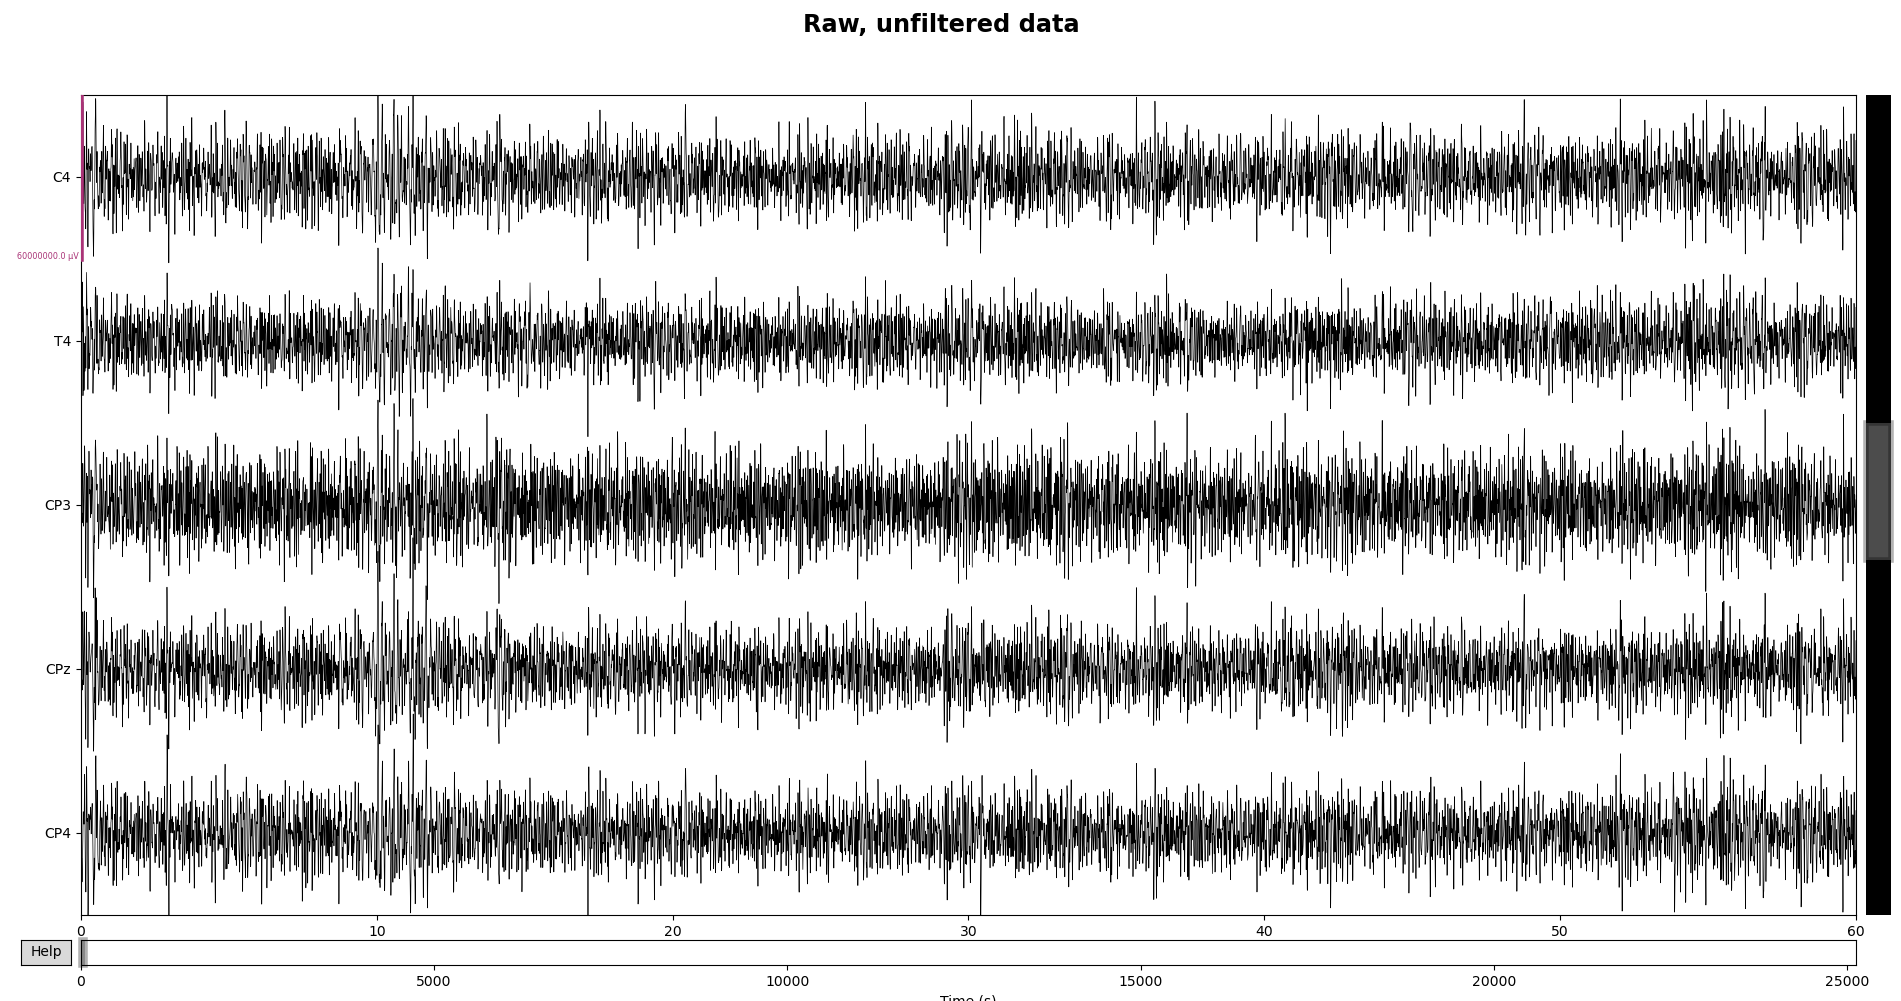

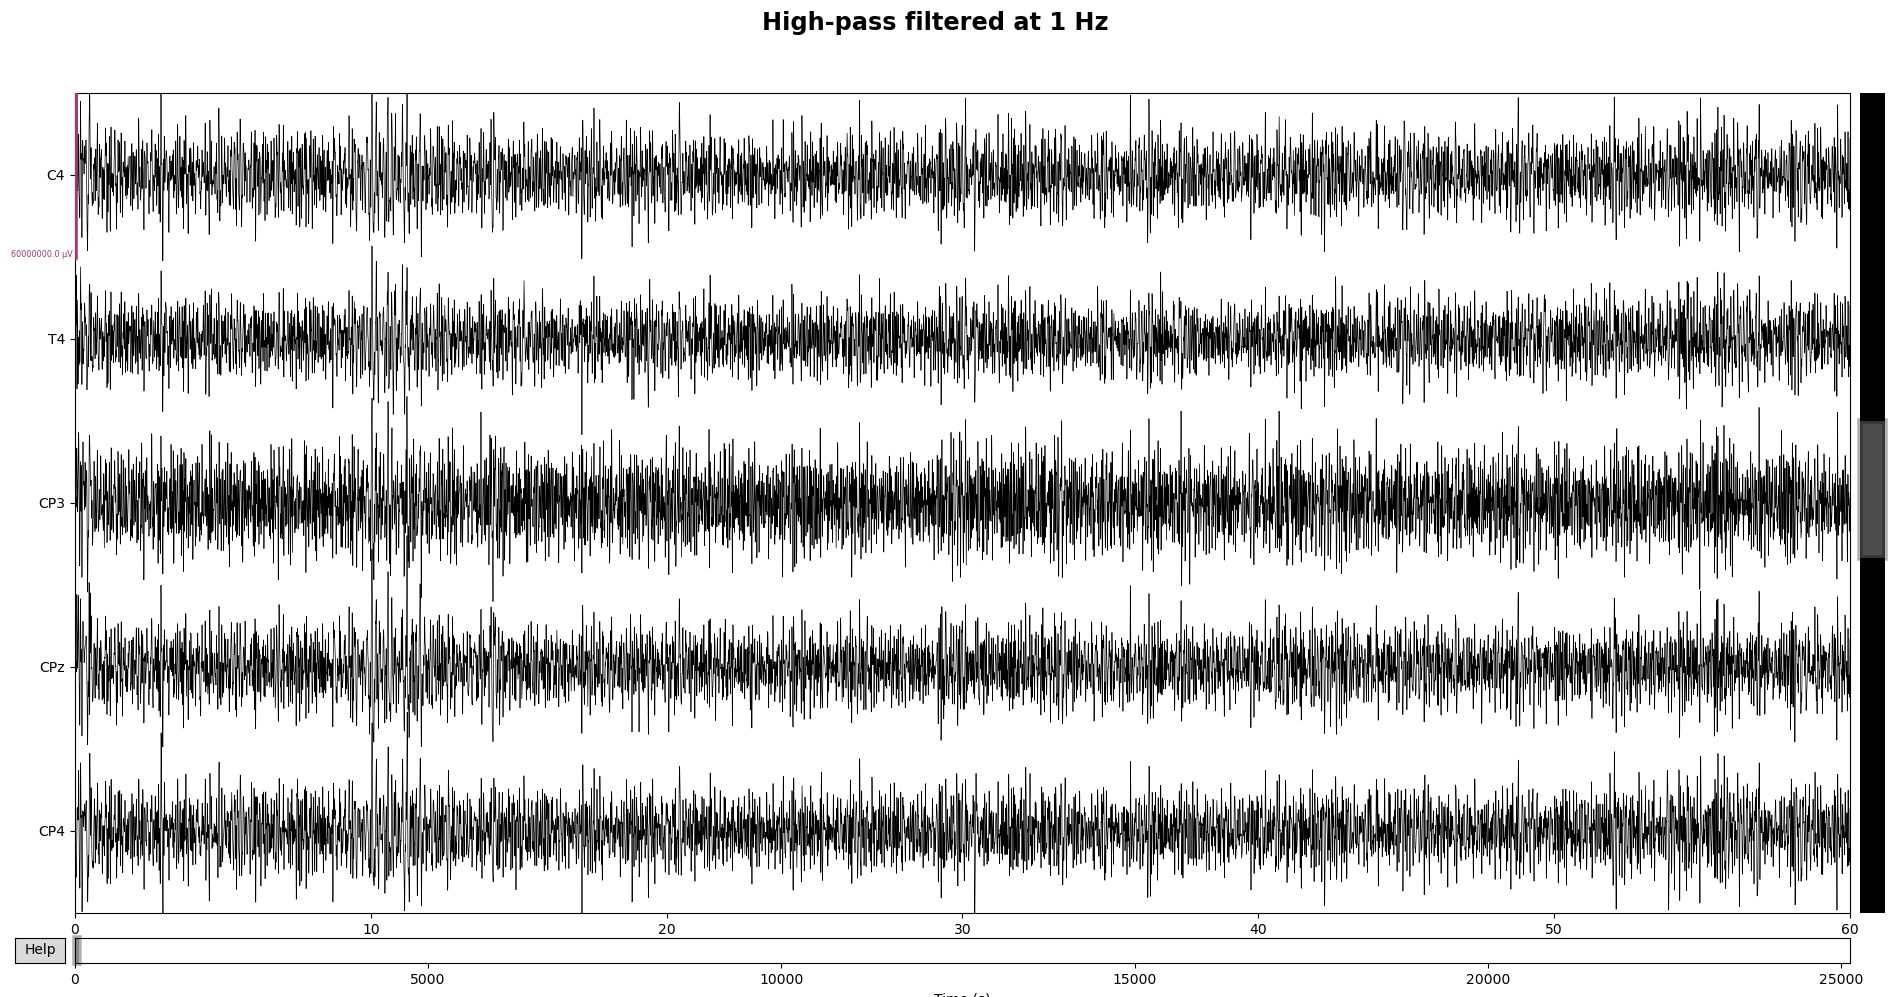

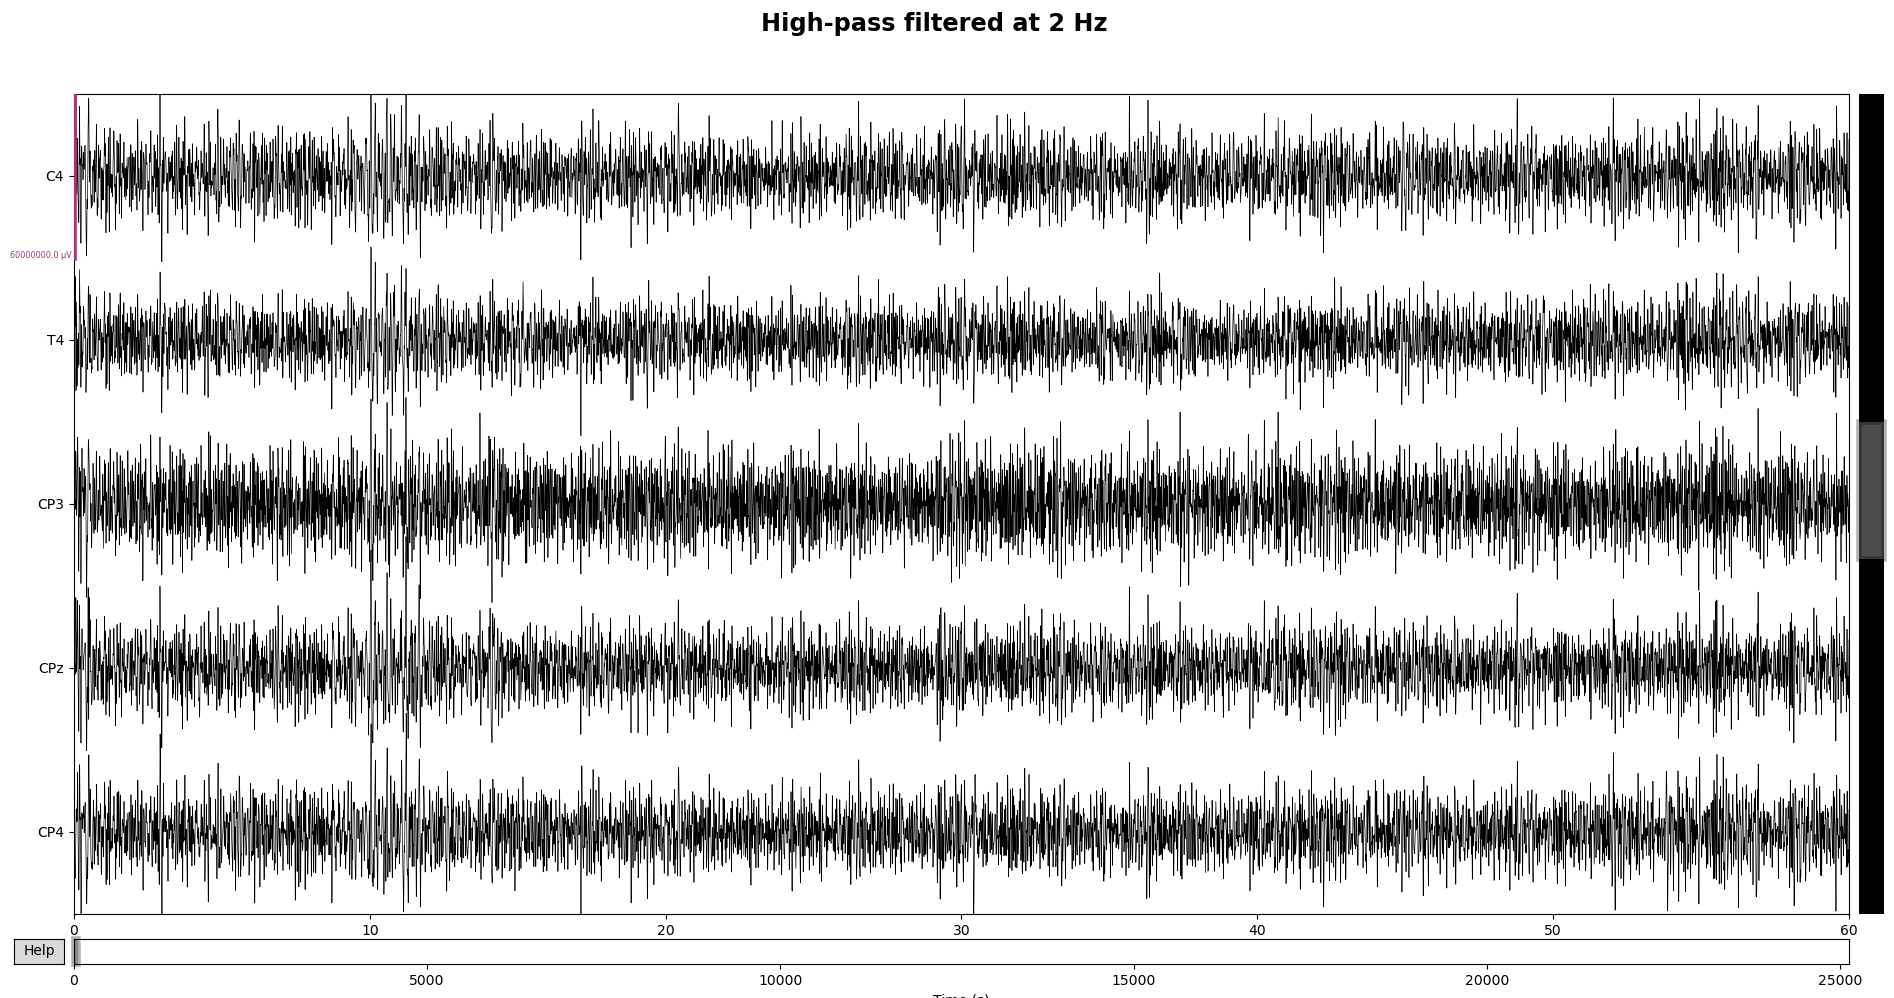

### Identifying channels to drop from analysis

The original authors visually inspected all the data and used their judgment and experience with BCI data to manually decide which channels to exclude from analysis. In order to inform my choices on filtering, I will graph and examine those problematic signals to inform my filtering choices.

Here is the table showing all the exclusions the authors made: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4436356/table/pone.0123727.t001/

Most importantly, the original authors made a typo in their list of exclusions. They consistently note excluding channel F6, but their list of channels which they recorded does not include F6. As a result, I looked through a number of the datasets to identify which channel is likely to have been that mystery channel.

**Based on my visual inspection of the data, it appears that F8 is likely to channel that was removed** - it looks similar to the other channels that were removed, plagued by very high frequency fluctuation and very high amplitudes. For example:

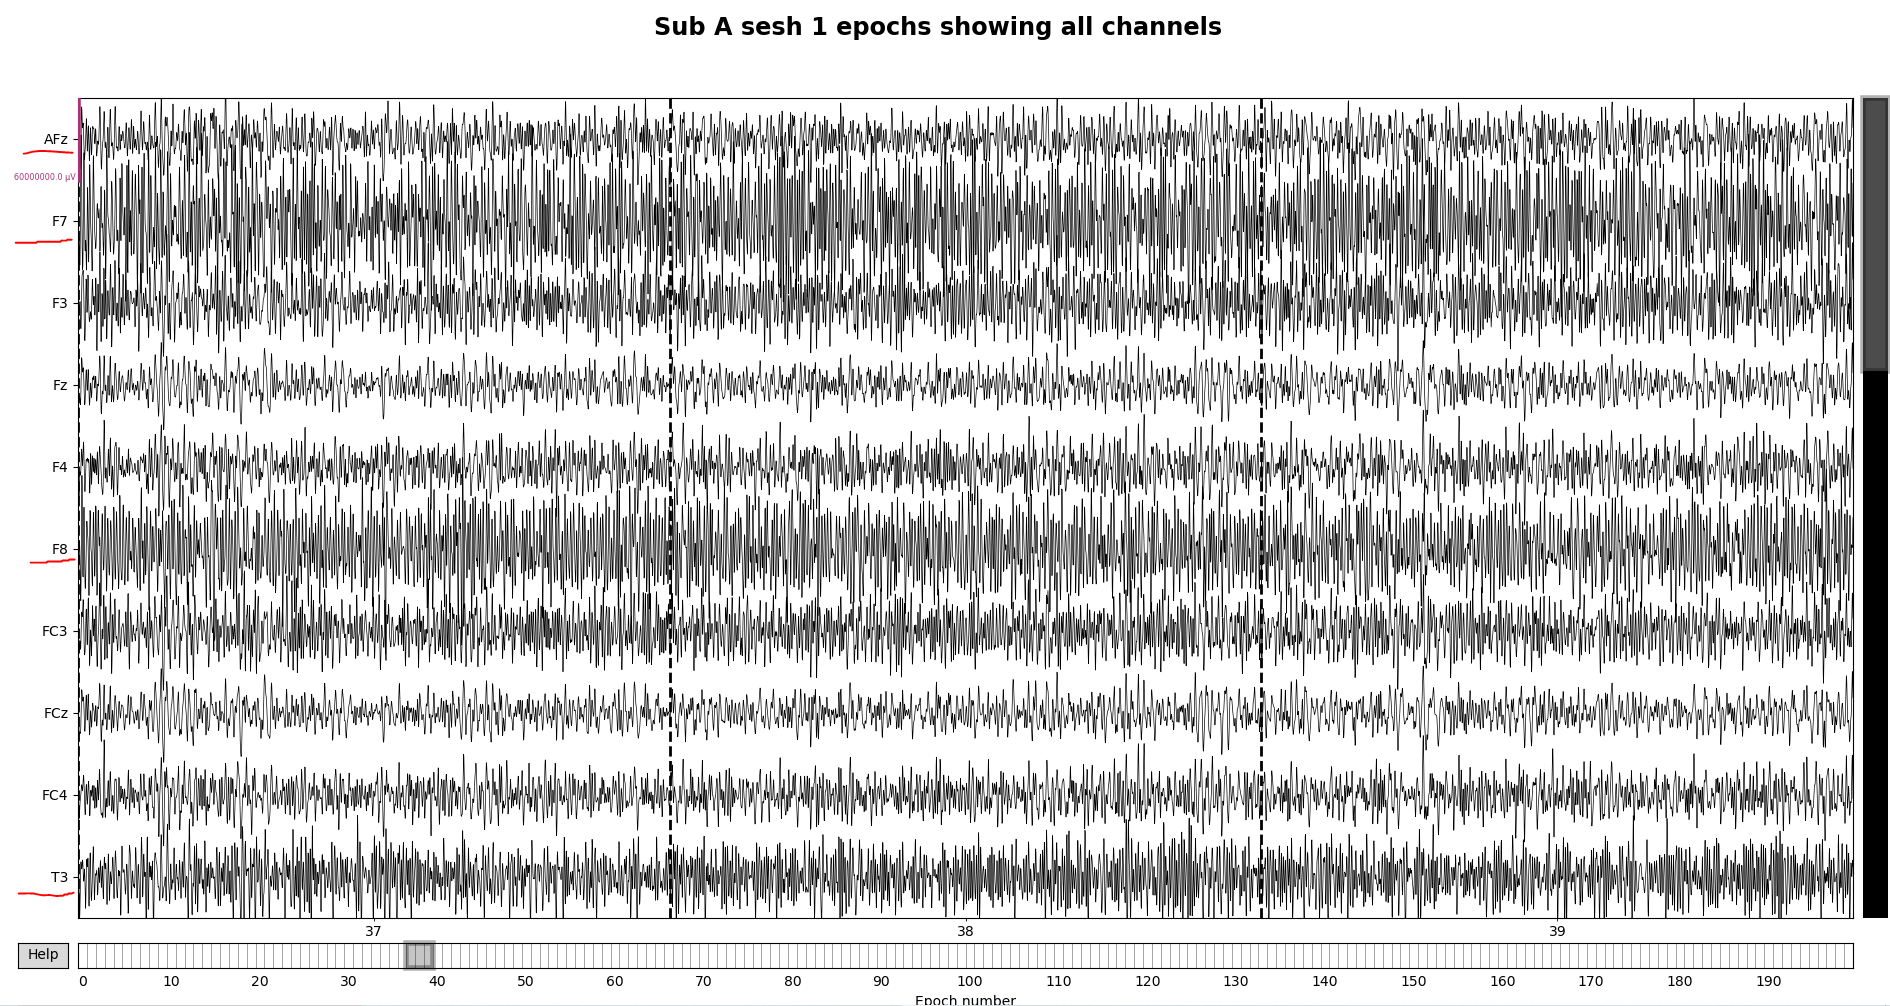

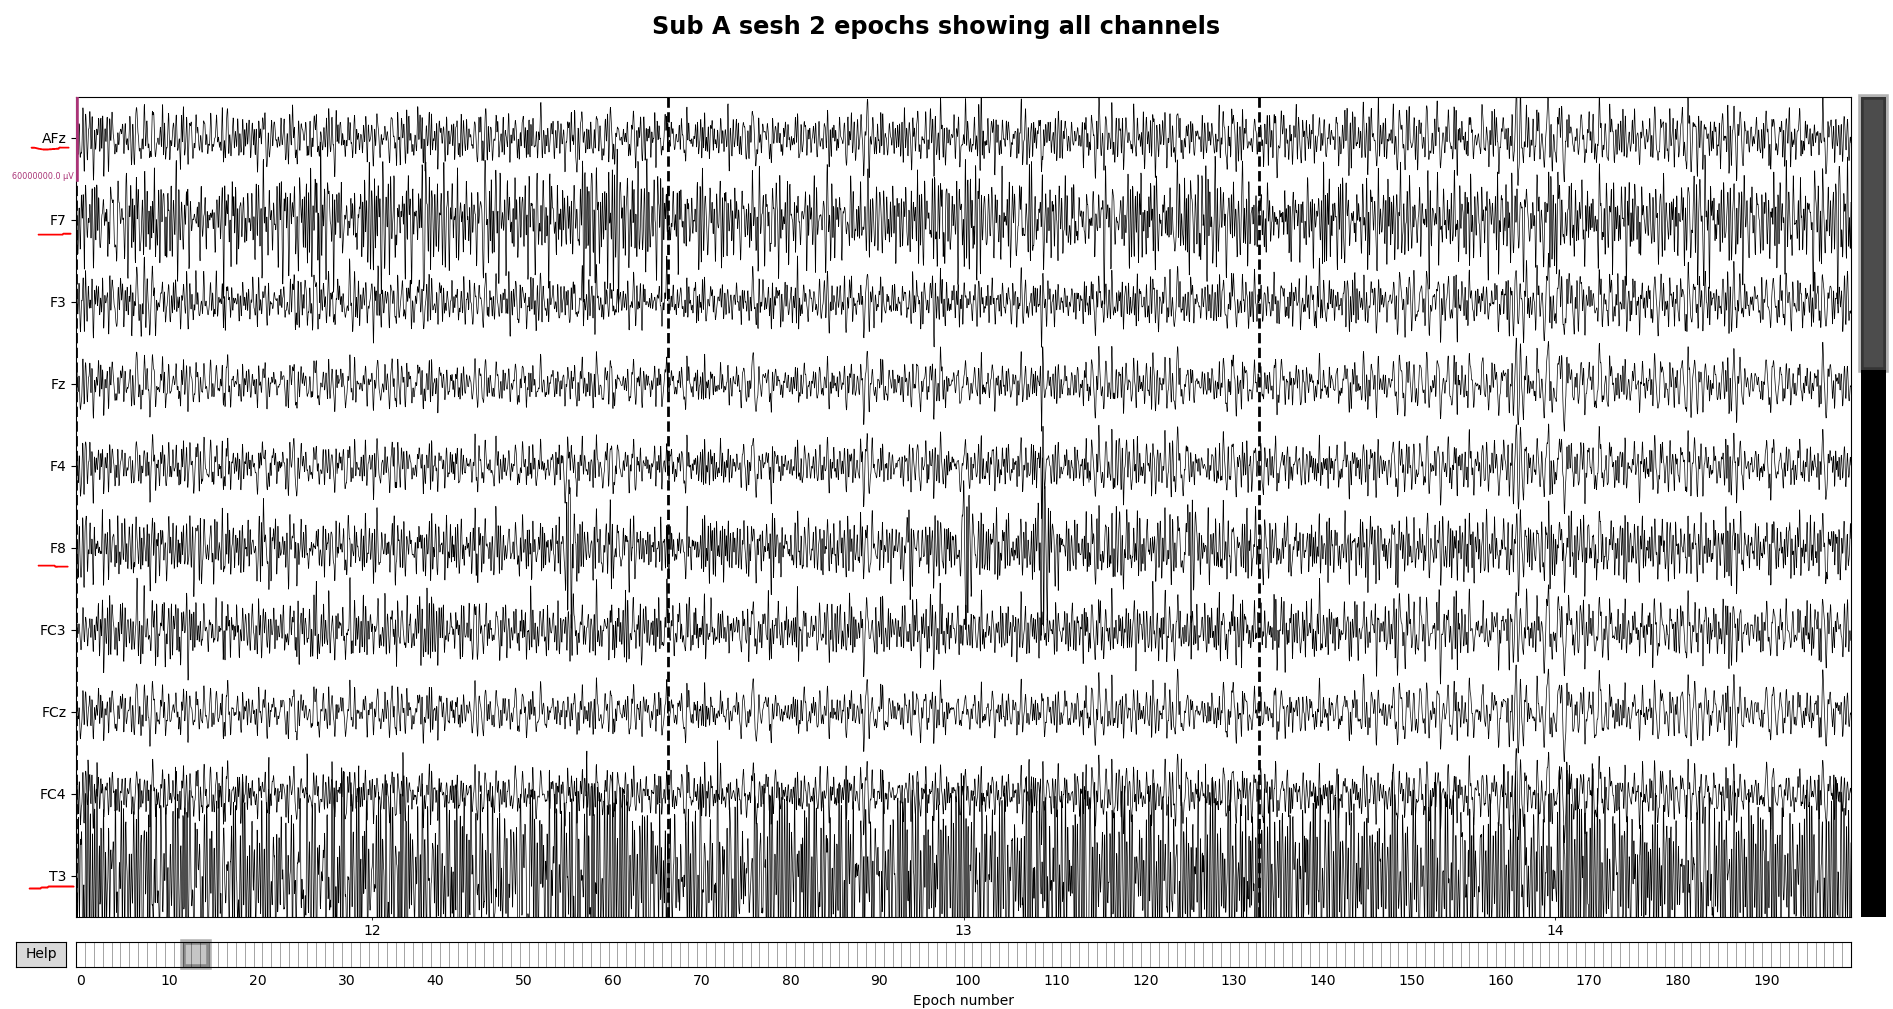

From their table of exclusions, here is the relevant excluded list for subject A as an example:

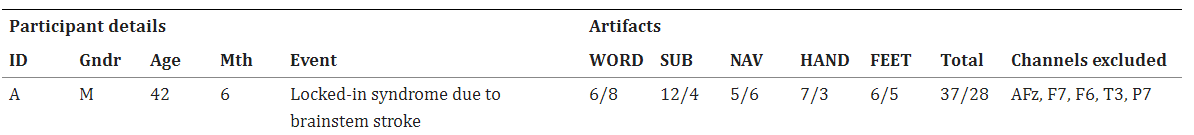

**Here is the code to generate those images - you can navigate across channels and epochs in the pop up windows that appear**

In [18]:
#Create epoch objects without altering the underlying data
epoch_dict = {}
for key, value in raw_dict.items():
    epoch_dict[key] = mne.Epochs(value, events=event_dict[key], 
                                event_id=events_explained, 
                                tmin=-3, tmax=7, 
                                baseline=None,
                                preload=True,
                                verbose=0)

In [24]:
fig = epoch_dict['sub_A_sesh_1'].plot(scalings=30, 
                                                 n_epochs=3, 
                                                 n_channels=10)
fig.subplots_adjust(top=0.9)
fig.suptitle('Sub A sesh 1 epochs showing all channels', weight='bold', 
             size='xx-large');

Opening epochs-browser...
Closing epochs-browser...
Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


In [25]:
fig = epoch_dict['sub_A_sesh_2'].plot(scalings=30, 
                                                 n_epochs=3, 
                                                 n_channels=10)
fig.subplots_adjust(top=0.9)
fig.suptitle('Sub A sesh 2 epochs showing all channels', weight='bold', 
             size='xx-large');

Opening epochs-browser...


### Signal Space Projection (SSP)

At this point, I'm not sure if SSP will help clean up artifacts. Let's visualize our data in a different way to look for artifacts.

### For visualizations at the end of the project

Once I find out which SSP projectors I'm going to keep on, I should chart the effect. Here's how to do it.

In [ ]:
#Lets try visualizing these projectors - first data without projectors
epoch_dict['sub_A_sesh_1'].del_proj()
with mne.viz.use_browser_backend('matplotlib'):
    fig = epoch_dict['sub_A_sesh_1'].plot(scalings=30, n_epochs=3, 
                                          events=event_dict['sub_A_sesh_1'])
fig.subplots_adjust(top=0.9)  # make room for title
fig.suptitle('Without ECG projectors', size='xx-large', weight='bold')

In [ ]:
#Lets try visualizing these projectors - now with projectors
epoch_dict['sub_A_sesh_1'].add_proj(projs)
with mne.viz.use_browser_backend('matplotlib'):
    fig = epoch_dict['sub_A_sesh_1'].plot(scalings=5, n_epochs=3, 
                                         events=event_dict['sub_A_sesh_1'])
fig.subplots_adjust(top=0.9)  # make room for title
fig.suptitle('With ECG projectors', size='xx-large', weight='bold')

### Setting up and visualizing the effects of ICA (independent components analysis)

**Rerun this code to generate new output, but code is fixed to resolve errors**

Our results indicate there is still a lot of noise in the data, so let's try to fix that with independent component analysis. We'll conduct on our epoched data, as it needs to occur after filtering, dropping bad epochs and channels, and should perform better after SSP as well.

I'll use a few  parameters across all ICA permutations:
1. Use the Picard ICA algorithm - should be both faster and more robust than other algorithms when sources are not entirely independent
2. Need to pass the data through a high pass filter at 1Hz (or higher) in all situations where ICA is used to avoid low frequency drifts distorting the ICA fit
3. Note I am not passing a random state, which means ICA values will vary slightly from test to test

To test this out and show some visualizations, we'll look at subject H session 1 for a change.

In [350]:
#filter the data with 1Hz high pass filter
H_filtered = raw_dict['sub_H_sesh_1'].filter(l_freq=1, h_freq=40,
                                             method='fir', 
                                             phase='zero', 
                                             verbose=0)
bad_channels = ['AFz', 'F7', 'F6']
channels_to_keep = [ch for ch in ch_names if ch not in bad_channels]

#Create epoch object with high-performing parameters at point of this writing
H_epoch = mne.Epochs(H_filtered, events=event_dict['sub_H_sesh_1'], 
                                            event_id=events_explained, 
                                            tmin=-3, tmax=5.5,
                                            preload=True,
                                            picks=channels_to_keep, verbose=0,
                                            detrend=None,
                                            baseline=None,
                                            reject={'eeg': 50},
                                            flat={'eeg': 15},
                                            reject_tmin=-0.2,
                                            reject_tmax=5.5)

#Create and apply projectors
H_projs = mne.compute_proj_epochs(H_epoch, n_eeg=5, verbose=0)
H_epoch.add_proj(H_projs[slice(None, 1, None)], verbose=0)
H_epoch.apply_proj(verbose=0)

#create and fit ICA object to our H epoch
ica = mne.preprocessing.ICA(n_components=5, method='picard', max_iter='auto')
ica.fit(H_epoch)
ica

Fitting ICA to data using 28 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)


C:\Users\brent\AppData\Local\Temp\ipykernel_11400\781987610.py:28: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(H_epoch, start=-0.2, stop=5.5)
C:\Users\brent\AppData\Local\Temp\ipykernel_11400\781987610.py:28: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): start, stop
  ica.fit(H_epoch, start=-0.2, stop=5.5)


Selecting by number: 5 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 1.0s.


<ICA | epochs decomposition, method: picard (fit in 26 iterations on 82726 samples), 5 ICA components explaining 78.8 % of variance (28 PCA components available), channel types: eeg, no sources marked for exclusion>

In [353]:
fig = H_epoch.plot(scalings=3, n_epochs=3, events=event_dict['sub_H_sesh_1'])
fig.subplots_adjust(top=0.9)  # make room for title
fig.suptitle('Before removing ICA components', size='xx-large', weight='bold');

Opening epochs-browser...


In [355]:
#To compare to original data, make a copy since ICA changes happen inplace
H_epoch_copy = copy.deepcopy(H_epoch)

#Now let's apply the first ICA component and visualize how it changed things
ica.apply(H_epoch_copy, exclude=[0, 1, 2, 3, 4])
fig = H_epoch_copy.plot(scalings=3, n_epochs=3, 
                        events=event_dict['sub_H_sesh_1'])
fig.subplots_adjust(top=0.9)  # make room for title
fig.suptitle('After removing ICA component 1', size='xx-large', weight='bold');

Applying ICA to Epochs instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (5 components)
    Zeroing out 5 ICA components
    Projecting back using 28 PCA components
Opening epochs-browser...


C:\Users\brent\AppData\Local\Temp\ipykernel_11400\206580183.py:5: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(H_epoch_copy, exclude=[0, 1, 2, 3, 4])


Closing epochs-browser...
Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none
Closing epochs-browser...
Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none
Closing epochs-browser...
Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


**Here are the resulting charts**

You can see that the ICA is making a difference - but it isn't clear which shapes will make it easier for our neural network to recognize different trials. As a result, we'll plan to gridsearch to find which combination of exclusions of ICA components (if any) improve our models.

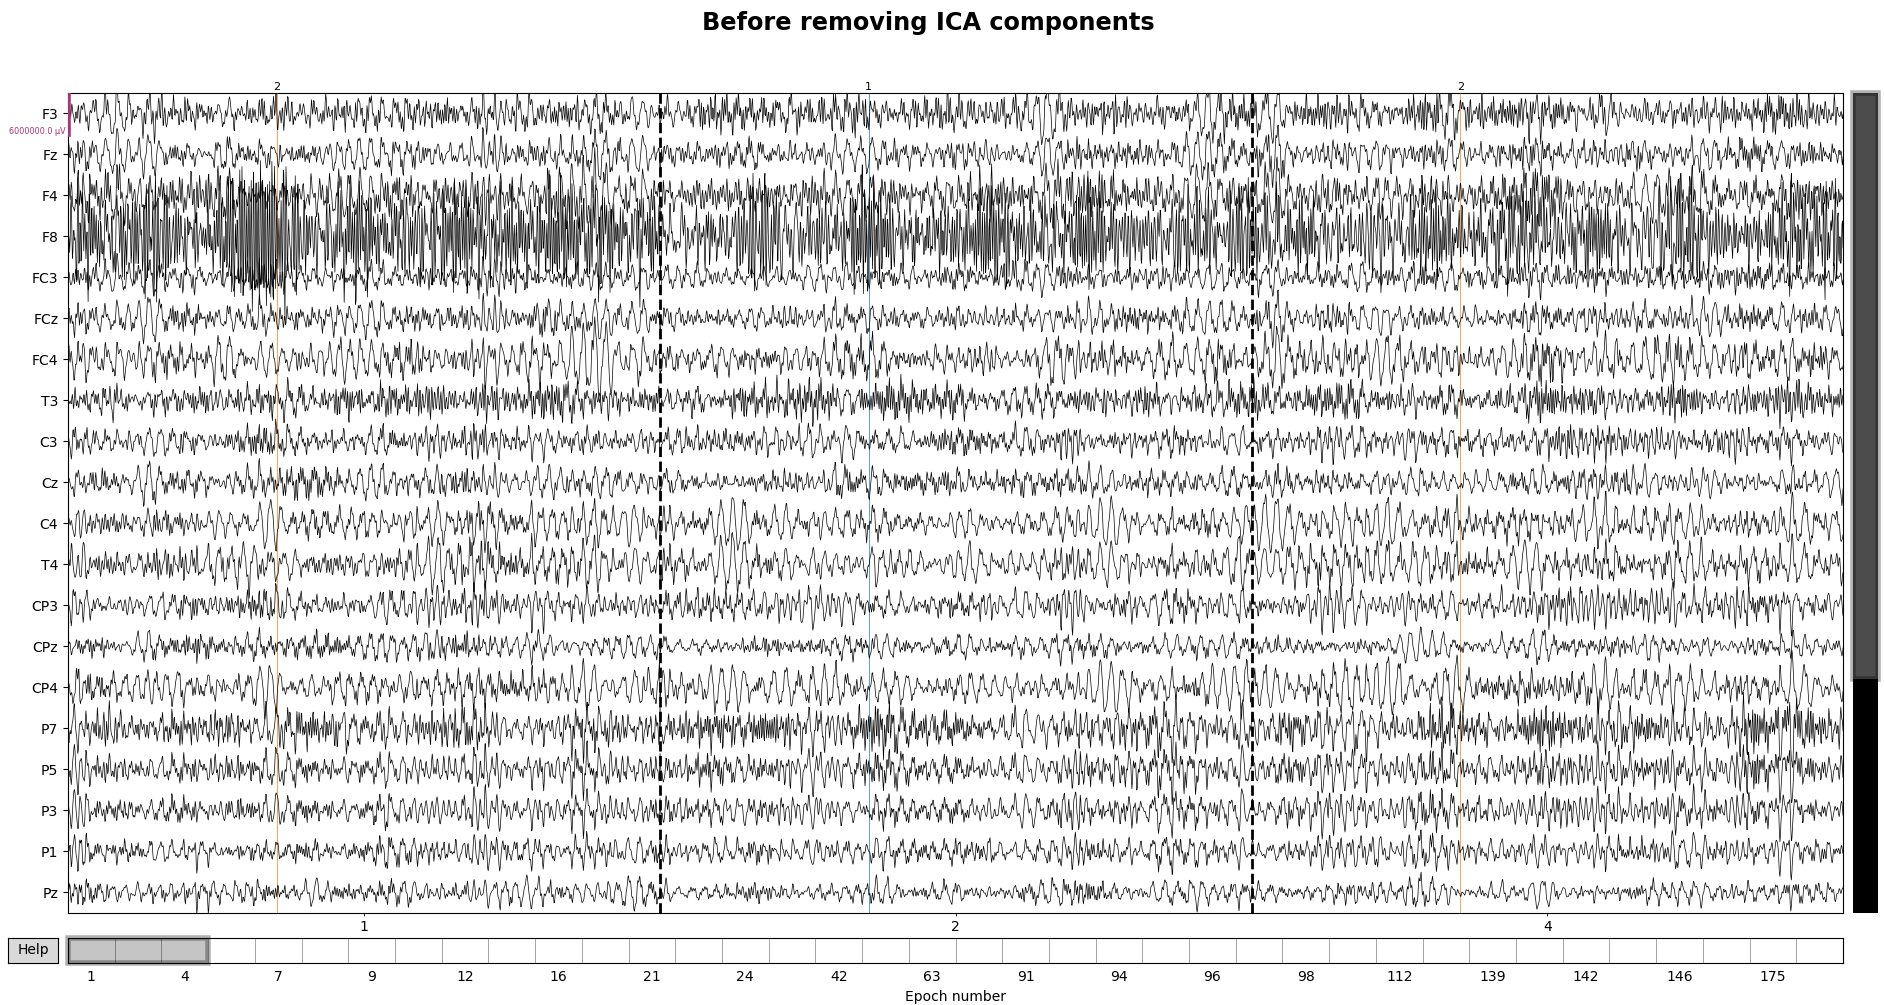

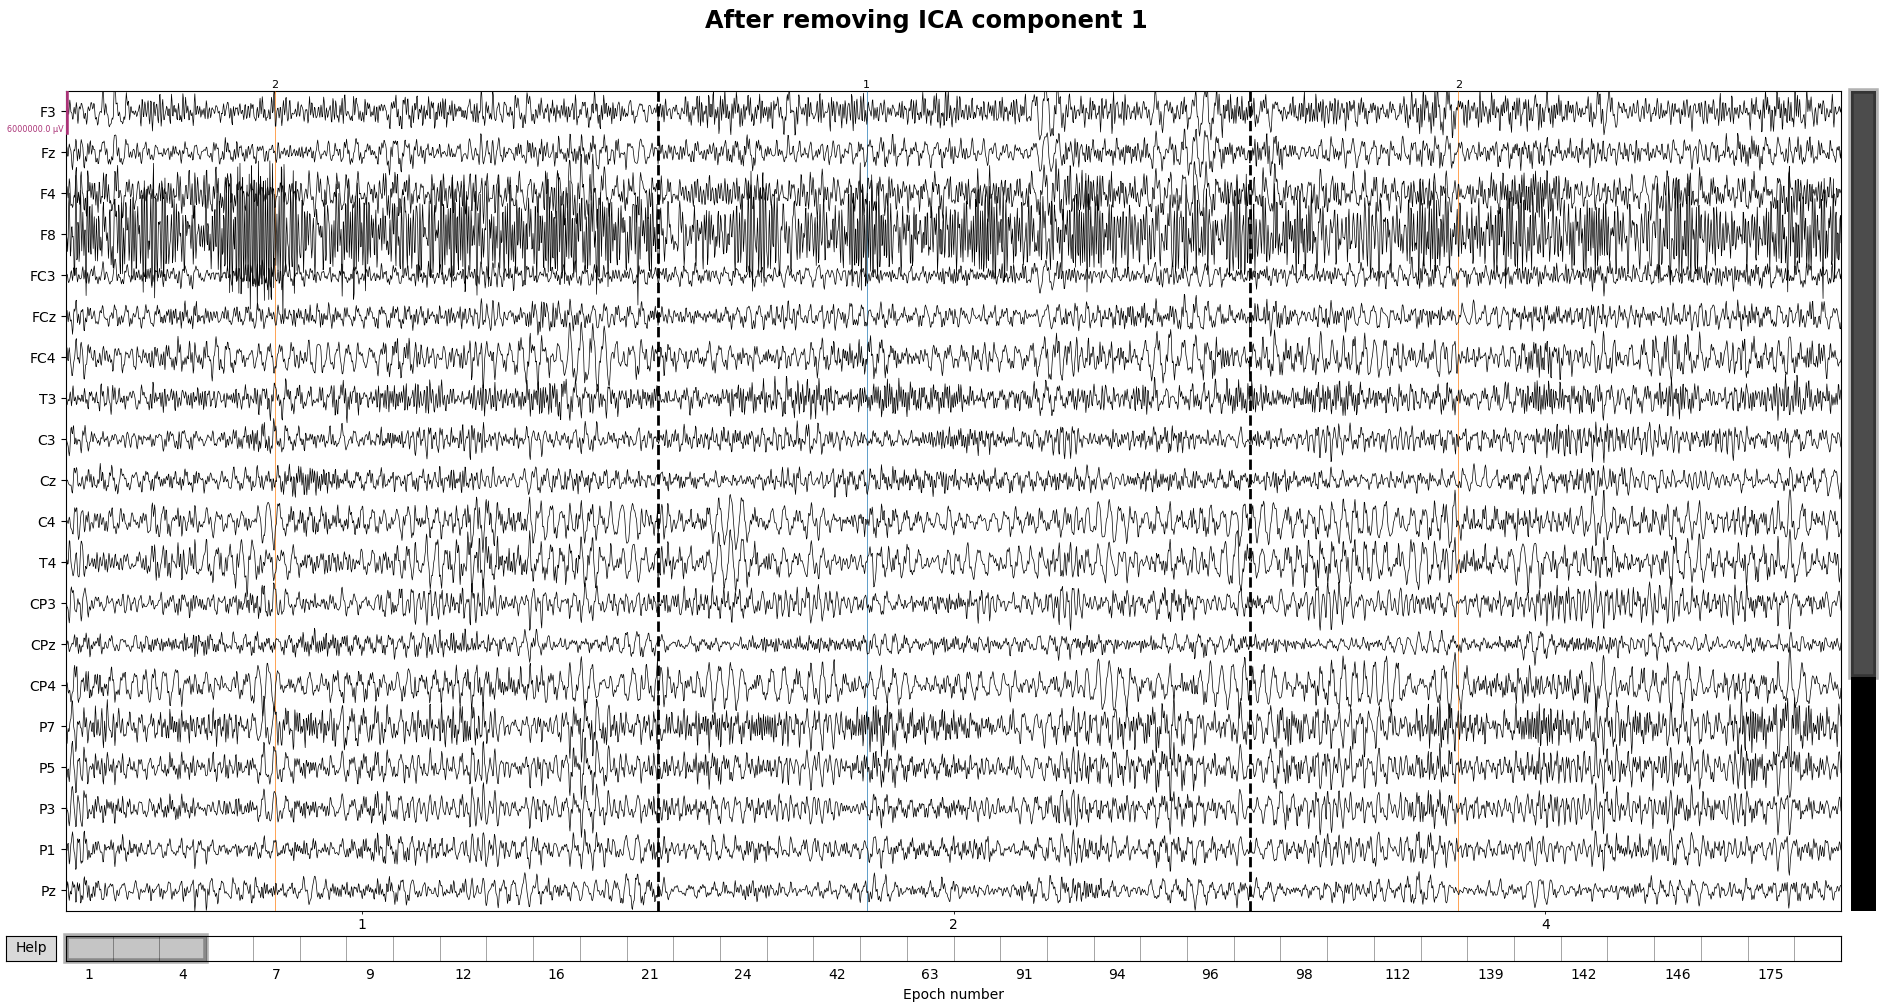

In [356]:
#To preserve ram lets delete the temporary variables we created
del H_epoch
del H_epoch_copy
del ica
del H_projs
del H_filtered

### Setting up and visualizing the effects of CSP (common spatial patterns)

Here it is, looks easy! https://mne.tools/stable/auto_tutorials/machine-learning/50_decoding.html

In [369]:
np.reshape(H_epoch.get_data(), (H_epoch.shape[1], 
                                H_epoch.shape[0], 
                                H_epoch.shape[2]))

(200, 30, 1409)

In [374]:
H_epoch.get_data().shape

(200, 30, 1409)

In [373]:
np.reshape(y_dict['sub_H_sesh_1'], (200,))

array([4, 2, 1, 3, 2, 1, 3, 1, 4, 5, 2, 5, 3, 2, 1, 3, 2, 5, 4, 3, 1, 4,
       5, 4, 5, 4, 4, 2, 4, 5, 1, 1, 3, 5, 1, 1, 1, 5, 3, 3, 4, 5, 3, 2,
       4, 2, 3, 2, 2, 5, 4, 1, 2, 2, 5, 3, 2, 1, 5, 3, 3, 2, 4, 1, 5, 1,
       5, 2, 5, 4, 1, 4, 3, 4, 3, 2, 4, 5, 4, 4, 3, 2, 1, 2, 2, 1, 1, 5,
       1, 4, 3, 5, 3, 2, 3, 5, 4, 5, 1, 3, 3, 5, 2, 4, 1, 1, 1, 5, 5, 4,
       5, 2, 3, 5, 2, 3, 2, 3, 3, 2, 1, 4, 4, 4, 1, 2, 4, 3, 5, 1, 1, 1,
       3, 2, 5, 1, 2, 3, 4, 4, 4, 5, 2, 4, 2, 3, 1, 5, 5, 3, 3, 5, 1, 1,
       4, 3, 2, 2, 5, 3, 2, 4, 4, 5, 2, 3, 1, 4, 1, 2, 3, 4, 5, 1, 5, 5,
       2, 1, 5, 1, 4, 2, 1, 1, 3, 1, 2, 5, 4, 3, 5, 3, 5, 3, 4, 2, 4, 3,
       4, 2], dtype=uint8)

In [378]:
H_epoch = mne.Epochs(raw_dict['sub_H_sesh_1'], events=event_dict['sub_H_sesh_1'], 
                                            event_id=events_explained, 
                                            tmin=0, tmax=5.5,
                                            preload=True,
                                            verbose=0,
                                            detrend=None,
                    baseline=None)

csp = mne.decoding.CSP(n_components=4, reg=None, log=True, norm_trace=False)


csp.fit_transform(H_epoch.get_data(), np.reshape(y_dict['sub_H_sesh_1'], (200,))).shape

Computing rank from data with rank=None
    Using tolerance 22 (2.2e-16 eps * 30 dim * 3.3e+15  max singular value)
    Estimated rank (mag): 30
    MAG: rank 30 computed from 30 data channels with 0 projectors
Reducing data rank from 30 -> 30
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 24 (2.2e-16 eps * 30 dim * 3.6e+15  max singular value)
    Estimated rank (mag): 30
    MAG: rank 30 computed from 30 data channels with 0 projectors
Reducing data rank from 30 -> 30
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 23 (2.2e-16 eps * 30 dim * 3.4e+15  max singular value)
    Estimated rank (mag): 30
    MAG: rank 30 computed from 30 data channels with 0 projectors
Reducing data rank from 30 -> 30
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 23 (2.2e-16 eps * 30 dim * 3.5e+15  max singular value)
    Estimated rank (

(200, 4)

**pick up work here**
To implement CSP tomorrow I will have to do some relatively major surgery on my function - the shape of the tensor going into the neural network is going to be quite different - not even really appropriate for a CNN anymore, will need to be a traditional neural network.

For the CSP I need to experiment on the n_components it creates, definite thing to grid search on.

Also going to need a different tmin and tmax for the CSP - that'll be a whole new thing to worry about too. My function might be starting to creak if I try to throw CSP into it.

Should try an LDA on the CSP - but could also feed that into a traditional neural network as well (feed the LDA prediction in as an alternative input I mean). Could even go whole-ass crazy and do the following architecture:

CNN ---- CSP to LDA ------- CSP to NN
            NN
            NN

**Duplicating the filters from the study**
- Here is the article they reference with instructions on CSP: https://sci-hub.se/10.1109/MSP.2008.4408441

Notes from conversation with Anirudh:

- I should build a supervised network, that will get the best results
- I should just use tensorflow, don't worry about pytorch
- Make a 3 layer neural net, and feed the input into the last layer (or second to last layer) into tsne to make visualization
- He recommends building neural network progressively - start with a super simple neural net (like with excel data I make on a simple classification problem), put it into tsne and umap (umap keeps things more structurally correct)
- Then go to time series data - LSTM (which is an encoder) - in my neural net
- LSTM isn't going to work with 2500 data points per trial (it just won't run) - I could run a transformer model, but I'm not going to have time for that, instead he suggests getting down to 100 samples per LSTM (bunch of ways to do that, could take the median of every 25 measurements, or just take every 25th one)
- He highly recommends I visualize how each channel moves up and down - that will aid my knowledge hugely
    - I can even do matplotlib + animation (google that) to make a gif of how a channel moves in a trial
- I could also train with an auto encoder, it will take an input in (like you could feed it an image) - and it will try to recreate the signal you are feeding it
    - Google cnn autoencoder
- It may be the only transformation I need to do is put all my datapoints between 0 and 1 - maybe a log transformation - in general the neural nets will handle the transformations, but the cleaner the data I feed them, the better the neural net will work
- Could maybe do convolutional neural network (CNN) instead of LSTM (basically treat the signal as an image instead of timeseries data)
- I should look up the study where they used an auto encoder to have people watch youtube on eeg, and then use the eeg to rebuild the youtube video


Links he used / took me to:
https://projector.tensorflow.org/
'auto encoder in deep learning'
'TSNE' visualizer
https://www.tutorialspoint.com/time_series/time_series_lstm_model.htm#:~:text=It%20is%20special%20kind%20of,layers%20interacting%20with%20each%20other. 


Based on further research:
- Looks like there is already a package to implement tensorflow models with data formatted as mne handles it: https://github.com/zubara/mneflow
    - Unclear if this will help me just apply their three built models to my data or provide an easier path to creating tensorflow models on my data
    
Conversation with team who did deeplearning at brain conference:
- They used a convolutional neural network
- They downsampled their data before passing into their model - you have to make sure the frequency you are passing in is representative, you are capturing the signal content, you need to do some pre-processing and make sure the signal you want to capture is represented at the frequency you are downsampling to - e.g., if you are capturing a 50Hz signal you need to maintain at least 50 frames per second, probably more like 100 to get peaks and troughs
- Each convolution only runs across time - they passed in very small periods of time, and only a single electrode worth of data
- They passed in each channel independently into a model - the model don't know what the part of time or what channel it is seeing, it sees 2 x 100 chunks of data, in the training data its seeing the same event 16 times for
- They recommended that I could look for which channels are highly correlated with each other and then drop down to one of those channels 
- They are from UCLA! Consider reaching out here in the near future. From the video session Davide seemed like the principal, Emily #2, Ebrahim #3 (but also the one who was actually writing code, so good for me to reach out to)
    - Davide Ciliberti
    - Emily Mankin
    - Ebrahim Feghhi
    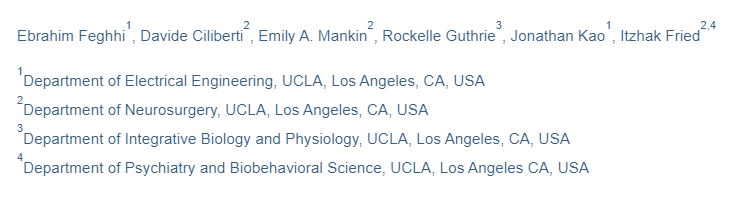
    
Conversation with Sophie:
- Look at resampling in MNE to deal with my bad graphs on the trials - it looks like mne calls this temporal decimation
- Follow the tutorials in MNE - preprocessing, filtering, and resampling data sections in particular, artifact detection
- Read about differencing - method for series resampling

Good article with a full run down of using MNE for their full project:
https://natmeg.se/mne_preprocessing/1-MNE_from_raw_to_epochs_evoked.html

Another good article I found - 0.1 Hz high pass and 40 Hz low pass. No magic to EEGnet they say. https://peijin.medium.com/deep-learning-for-eegs-nad-bci-some-notes-and-some-warnings-28cfc3015a98

**If I have to restart kernel, below to get test_df up and running again**

In [ ]:
test_df = pd.read_csv('data/preprocessing_grid_search.csv')
test_df = test_df.replace(np.nan, None, regex=True)